# Analysis of trained models and training logs
This notebook shows how to load, process, and analyze logs that are automatically generated during training. It also demonstrates how to make plots to examine performance of a single model or compare performance of multiple models.

Prerequisites:
- To run this example live, you must train at least two models to generate the trained log directories and set the paths below.

Each log directory contains the following:
- args.txt: the arguments fed into regression.py to train the model
- split: the train-tune-test split used to train the model
- final_evaluation.txt: final evaluation metrics (MSE, Pearson's r, Spearman's r, and r^2) on each of the split sets
- predictions: the model's score predictions for every variant in each of the split sets
- the trained model itself: see the inference notebook for more information on how to use this

This codebase provides several convenient functions for loading this log data.

In [1]:
# reload modules before executing code in order to make development and debugging easier
%load_ext autoreload
%autoreload 2

In [2]:
# this jupyter notebook is running inside of the "notebooks" directory
# for relative paths to work properly, we need to set the current working directory to the root of the project
# for imports to work properly, we need to add the code folder to the system path
import os
from os.path import abspath, join, isdir, basename
import sys
if not isdir("notebooks"):
    # if there's a "notebooks" directory in the cwd, we've already set the cwd so no need to do it again
    os.chdir("..")
module_path = abspath("code")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from scipy.stats import pearsonr, spearmanr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import analysis as an

# Define the log directories
To run this script live, you must train at least two models. As an example, we are using the avGFP linear regression and fully connected models, trained using the arguments in `pub/regression_args/avgfp_main_lr.txt` and `pub/regression_args/avgfp_main_fc.txt`. You can use these or train your own models. For comparing performance of many trained models, you must write your own function to collect the log directory names. Then, using them with this example is then relatively straightfoward. 

In [4]:
log_dir_lr = "output/training_logs/1c0p_log2_pool_cnn_wt_score"
log_dir_fc = "output/training_logs/1c0p_pool_cnn_wt_score"
log_dirs = [log_dir_lr, log_dir_fc]

# Loading score predictions (single model)
The utility function uses the dataset tsv as a base and adds columns for the set name (train, tune, test, etc) and the predicted score.

In [ ]:
ds_lr = an.load_predictions(log_dir_lr)
ds_lr.head()

,variant,num_mutations,score,score_wt_norm,set_name,prediction
0,Y236L,1.0,-0.626055,0.872657,train,0.932812
1,A124C,1.0,-0.507738,0.972950,train,0.969930
2,"A124D,C363E",2.0,-0.636971,0.997775,train,0.887964
3,"A124D,D167T",2.0,-0.622466,1.011723,train,1.002456
4,"A124D,G230D,R418M",3.0,-0.619105,1.018956,train,0.961407


# Loading evaluation metrics (single model)

In [32]:
metrics_lr = an.load_metrics(log_dir_lr)
metrics_lr

,set,mse,pearsonr,r2,spearmanr,epoch,early
0,train,0.008058,0.919590,0.835341,0.899855,52,True
1,tune,0.017546,0.797900,0.636114,0.782472,52,True
2,test,0.016749,0.806138,0.648279,0.781508,52,True


Sometimes it is convenient to have access to other aspects of the model, such as the learning rate and batch size. You can load the regression arguments as a dictionary using `an.load_args()`. Or, you can use `an.load_metrics_and_args` to load both the metrics and arguments in a single dataframe. The combined dataframe is set up so that each row can be a different model, which helps with comparisons between models. 

In [33]:
met_args_lr = an.load_metrics_and_args(log_dir_lr)
met_args_lr

IndexError: list index out of range

# Evaluating a single model
The dataframe contains variants from all sets (train, tune, test, etc), so if you are interested in a single set, you must select just those variants.

In [36]:
# before creating the testset-only dataframe, add a column with mean absolute error, used below
ds_lr["abs_err"] = np.abs(ds_lr["score_wt_norm"] - ds_lr["prediction"])

# create a subset view of the dataframe containing only test set variants
ds_lr_stest = ds_lr.loc[ds_lr.set_name == "test"]

## Scatterplot of predicted vs. true score

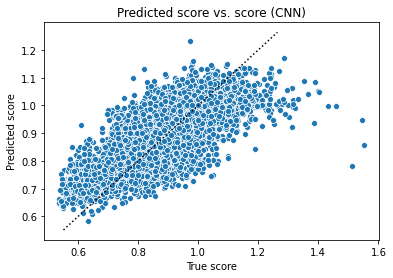

In [37]:
fig, ax = plt.subplots(1)
sns.scatterplot(x="score_wt_norm", y="prediction", data=ds_lr_stest, ax=ax,)
# draw a line of equivalence
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')  
ax.set(ylabel="Predicted score", xlabel="True score", title="Predicted score vs. score (CNN)")
plt.show()
plt.close(fig)

## Mean absolute error by number of mutations

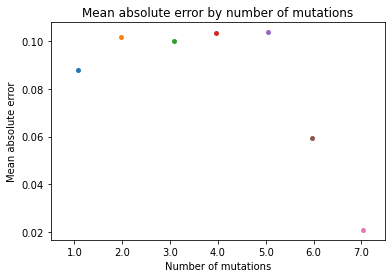

In [25]:
# plot the mean absolute error vs. number of mutations
# can do this more easily with pandas groupby, apply
grouped_mean = ds_lr_stest.groupby("num_mutations", as_index=False).mean()
fig, ax = plt.subplots(1)
sns.stripplot(x="num_mutations", y="abs_err", data=grouped_mean[grouped_mean.num_mutations < 13], ax=ax)
ax.set(ylabel="Mean absolute error", xlabel="Number of mutations", title="Mean absolute error by number of mutations")
plt.show()
plt.close(fig)

## Additional evaluation metrics
The regression training script automatically computes a few metrics, but you can also use the true and predicted scores to compute your own. Here, let's recompute Pearson's correlation coefficient and compare it to the same metric computed during training.

In [26]:
my_pearsonr = pearsonr(ds_lr_stest["score"], ds_lr_stest["prediction"])[0]
my_pearsonr

0.49816008380520244

In [28]:
# the pearsonr from the metrics dataframe
met_args_lr.loc[0, "test_pearsonr"]

NameError: name 'met_args_lr' is not defined

There's a small amount of floating point imprecision, but otherwise the values are identical.

In [13]:
np.isclose(my_pearsonr, met_args_lr.loc[0, "stest_pearsonr"])

True

# Loading score predictions and metrics (multiple models)
The functions used above also accept lists of log directories. For loading predictions, you can optionally specify column names, otherwise the column names will be automatically labeled by number. 

In [29]:
ds = an.load_predictions(log_dirs, col_names=["lr", "fc"])
ds.head()

,variant,num_mutations,score,score_wt_norm,set_name,lr,fc
0,Y236L,1.0,-0.626055,-0.196513,train,-0.143869,0.932812
1,A124C,1.0,-0.507738,-0.039562,train,-0.051611,0.969930
2,"A124D,C363E",2.0,-0.636971,-0.003214,train,-0.006724,0.887964
3,"A124D,D167T",2.0,-0.622466,0.016814,train,-0.016191,1.002456
4,"A124D,G230D,R418M",3.0,-0.619105,0.027092,train,-0.000448,0.961407


Loading metrics is also straightforward. Note that `an.load_metrics()` does not support multiple log dirs, only `an.load_metrics_and_args()`.

In [15]:
metrics = an.load_metrics_and_args(log_dirs)
metrics

,uuid,cluster,process,log_dir,dataset_name,dataset_file,wt_aa,wt_ofs,net_file,encoding,...,train_r2,train_spearmanr,tune_mse,tune_pearsonr,tune_r2,tune_spearmanr,stest_mse,stest_pearsonr,stest_r2,stest_spearmanr
0,DKPQxV5s,local,local,output/training_logs/log_local_local_2020-09-2...,avgfp,,,,network_specs/lr.yml,"one_hot,aa_index",...,0.705897,0.858721,0.367826,0.820646,0.672916,0.856183,0.365287,0.821362,0.674514,0.854083
0,RbLfpQvW,local,local,output/training_logs/log_local_local_2020-09-2...,avgfp,,,,network_specs/fcns/fc-3xh100.yml,"one_hot,aa_index",...,0.946306,0.866882,0.083971,0.963427,0.925330,0.862950,0.076445,0.967028,0.931884,0.861830


# Comparing multiple models

Make multiple scatterplots for different models. Note again, we must subset the dataframe to select our desired train/tune/test set.

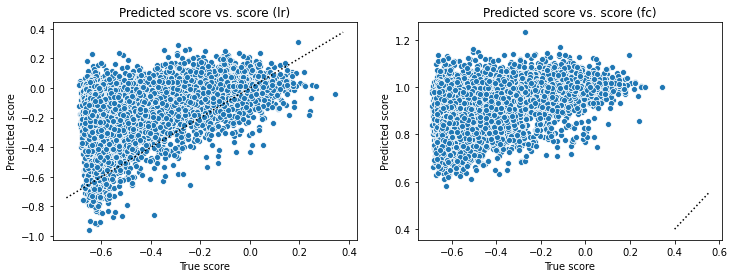

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, pred_col in enumerate(["lr", "fc"]):
    ax = sns.scatterplot(x="score", y=pred_col, data=ds[ds.set_name == "test"], ax=axes[i])
    # draw a line of equivalence
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    ax.plot(lims, lims, ':k')  
    ax.set(ylabel="Predicted score", xlabel="True score", title="Predicted score vs. score ({})".format(pred_col))
plt.show()
plt.close(fig)

Compare performance metrics between datasets.

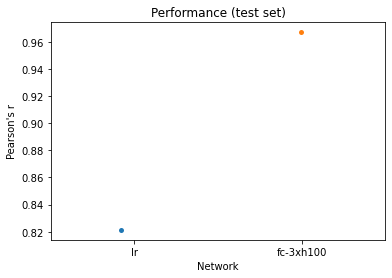

In [17]:
metrics["parsed_net_file"] = metrics["net_file"].apply(lambda nf: basename(nf).split(".")[0])
fix, ax = plt.subplots(1)
ax = sns.stripplot(x="parsed_net_file", y="stest_pearsonr", data=metrics)
ax.set(xlabel="Network", ylabel="Pearson's r", title="Performance (test set)")
plt.show()
plt.close(fig)